In [1]:
import matplotlib.pyplot as plt
import matplotlib
import pandas as pd
import numpy as np
import scipy as sp
import seaborn as sb
# actively reload module (during working on analyse_embeddings.py)
import importlib
import matplotlib.image as mpimg
import mat73
font = {'family' : 'Helvetica',
        #'sans-serif': ['Helvetica'],
        'weight' : 'normal',
        'size'   : 8}

matplotlib.rc('font', **font)

### COLOR definitions ###
#colors of undistorted and distorted mesh
color_undist = np.array([0,105,170])/255
color_dist = np.array([200,80,60])/255

# for yaw, pitch and roll
colors_ypr = [ np.array([210,150,0])/255,
               np.array([80,170,200])/255,
               np.array([175,110,150])/255]

# for undistorted, add 1 add 3
colors_add1 =  np.array([50,110,30])/255
colors_add3 =  np.array([200,80,60])/255

colors_add1 = sb.blend_palette(['#214017','#326e1e','#4ad41c'],13)
colors_add3 = sb.blend_palette(['#994738','#ee5c43','#ed8e7d'],13)

color_dynobs = np.array([130,185,160])/255
color_statobs = np.array([215,180,105])/255
 #sb.color_palette("Oranges")



#f6bd60, #139a43, #0eb1d2, #805d93, #c05746


## FoV size of virtual frame
fov = [58, 58, 41, 39] # left, right, bottom, top extent of fov in degree


# Load data for statistics:
- scaling functions for each subject
- behaviour from tracking data

In [2]:
scales_df = pd.read_pickle('./data/scaling.pkl')
scores_df = pd.read_pickle('./data/scores.pkl')
behaviour_df = pd.read_pickle('./data/behaviour.pkl')
omega_df = pd.read_pickle('./data/omega.pkl')

In [3]:
behaviour_df= behaviour_df.sort_values('subj')

In [4]:
# Define head movers
behaviour_df['head_mover'] = [True,True,True,True,False,False,True,False,True,False,True,False,False]
behaviour_df['upper_gaze'] = behaviour_df.mean_gaze_lat > behaviour_df.mean_gaze_lat.median()

In [5]:
behaviour_df = pd.merge(behaviour_df,omega_df,on='subj')

In [6]:
behaviour_df

,subj,mean_yaw,mean_pitch,mean_roll,mean_gaze_long,mean_gaze_lat,std_gaze_long,std_gaze_lat,head_mover,upper_gaze,omega_total,omega_mean,omega_std
0,3,3.572365,35.010177,3.546339,0.012889,0.160597,0.050005,0.160949,True,True,0.026069,0.011013,0.002111
1,4,2.259497,17.984294,2.501632,0.096536,0.076129,0.088970,0.269460,True,False,0.060242,0.017742,0.005579
2,5,3.026637,23.291266,2.889885,-0.019423,-0.004797,0.065569,0.155997,True,False,0.031305,0.011932,0.005169
3,7,3.319216,29.752639,3.194700,0.022907,0.048067,0.058551,0.247168,True,False,0.038040,0.019255,0.005074
4,8,2.297724,2.813484,1.789300,-0.026326,0.010396,0.053835,0.179685,False,False,0.032418,0.009124,0.006000
5,9,4.872265,4.718672,1.503471,0.050868,-0.018980,0.148381,0.233142,False,False,0.069019,0.009639,0.007007
6,10,6.699512,16.949982,3.368017,-0.059780,0.184406,0.099800,0.149221,True,True,0.045774,0.017499,0.005735
7,11,3.277893,2.306937,2.073839,-0.048163,0.259247,0.053828,0.130740,False,True,0.022122,0.007552,0.005209
8,12,28.428942,14.515606,6.023434,0.011294,0.115606,0.166477,0.154849,True,True,0.078382,0.026716,0.009554
9,13,10.027222,6.382752,2.608019,-0.068775,0.517971,0.300770,0.194270,False,True,0.091233,0.020828,0.012387


In [7]:
omega_df

,subj,omega_total,omega_mean,omega_std
0,3,0.026069,0.011013,0.002111
1,4,0.060242,0.017742,0.005579
2,5,0.031305,0.011932,0.005169
3,7,0.038040,0.019255,0.005074
4,8,0.032418,0.009124,0.006000
5,9,0.069019,0.009639,0.007007
6,10,0.045774,0.017499,0.005735
7,11,0.022122,0.007552,0.005209
8,12,0.078382,0.026716,0.009554
9,13,0.091233,0.020828,0.012387


### Trivial trial / embedding acc. differences between head-mover vs non-head-mover

In [9]:
# statistical testing
from scipy.stats import mannwhitneyu

head_mover = behaviour_df['head_mover']
head_stable = np.invert(head_mover)


# remove one subj for test
head_stable.iloc[4] = False
scores_df.reset_index(inplace=True)

# test differences in embedding with mann-whitney U test = Wilcoxon rank-sum test
_ , p_emb_acc = mannwhitneyu(scores_df.emb_acc[head_mover],scores_df.emb_acc[head_stable])
print(p_emb_acc)
# trivial trial performance
_ , p_trivial_perform = mannwhitneyu(scores_df.trivial_perform[head_mover],scores_df.trivial_perform[head_stable])
print(p_trivial_perform)
# percentage of trials repeated at least once
_ , p_trial_repeated = mannwhitneyu(scores_df.trial_repeated[head_mover],scores_df.trial_repeated[head_stable])
print(p_trial_repeated)
# total trials
_ , p_total_trials = mannwhitneyu(scores_df.total_trials[head_mover],scores_df.total_trials[head_stable])
print(p_total_trials)

0.041636997606412075
0.006282522219846899
0.638888888888889
0.07323232323232323


C:\Users\Newton\AppData\Local\Temp\ipykernel_20984\1528382291.py:12: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([f"{tick*100:.0f}%" for tick in ax.get_yticks()])


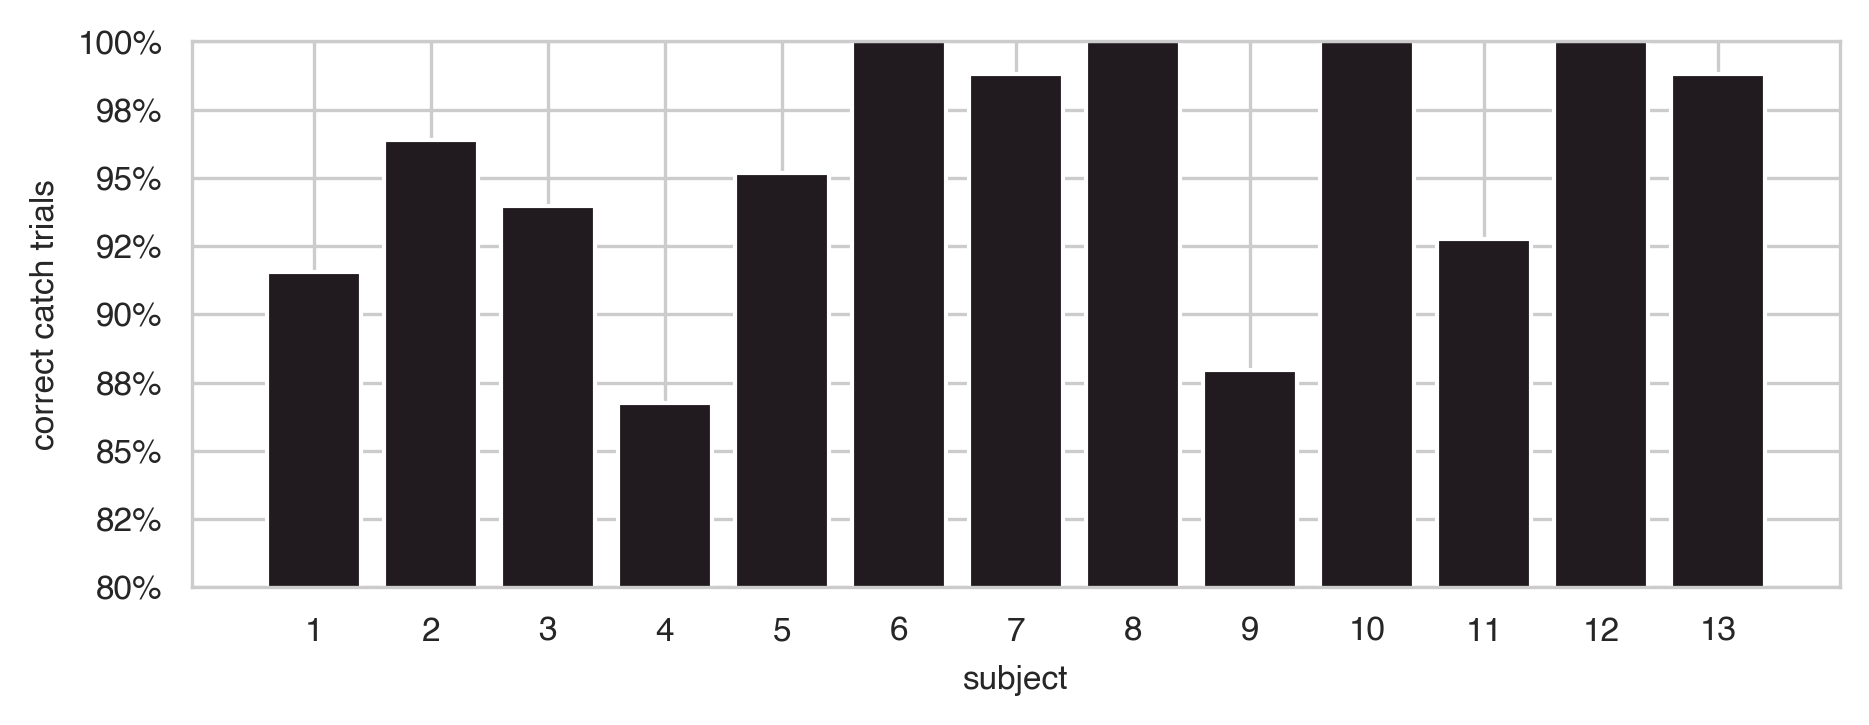

In [15]:
import matplotlib

matplotlib.rc('font', **font)
cm = 1/2.54
fig, ax = plt.subplots(figsize=(18*cm, 6*cm),dpi = 300)
n_subj = 13
w = 0.25
plt.bar(range(1,n_subj+1),scores_df.trivial_perform,color = '#211a1e')
plt.xticks(range(1,n_subj+1))
plt.ylim([0.8,1])
ax = plt.gca()
ax.set_yticklabels([f"{tick*100:.0f}%" for tick in ax.get_yticks()])
ax.set_xlabel('subject')
ax.set_ylabel('correct catch trials')
#plt.bar(x+w/2,y_stable,width = w,label='Static observer',yerr = y_stable_err,color = '#999999')
plt.savefig('catch_trial_performance.pdf',bbox_inches = 'tight', pad_inches = 0)


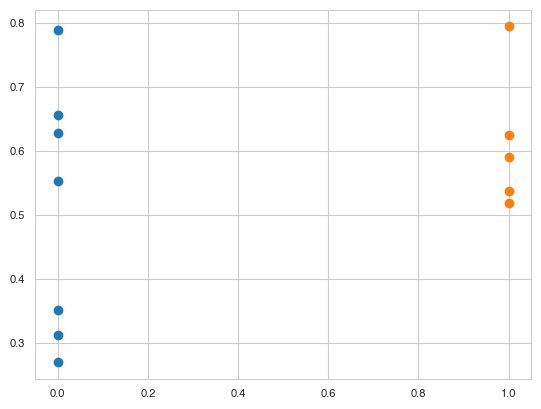

In [16]:
plt.scatter([0]*len(scores_df.trial_repeated[head_mover]),scores_df.trial_repeated[head_mover])
plt.scatter([1]*len(scores_df.trial_repeated[head_stable]),scores_df.trial_repeated[head_stable])

C:\Users\Newton\AppData\Local\Temp\ipykernel_20984\858072954.py:90: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[0].set_yticklabels(['{:,.0%}'.format(p) for p in vals])
C:\Users\Newton\AppData\Local\Temp\ipykernel_20984\858072954.py:92: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_yticklabels(['{:,.0%}'.format(p) for p in vals])


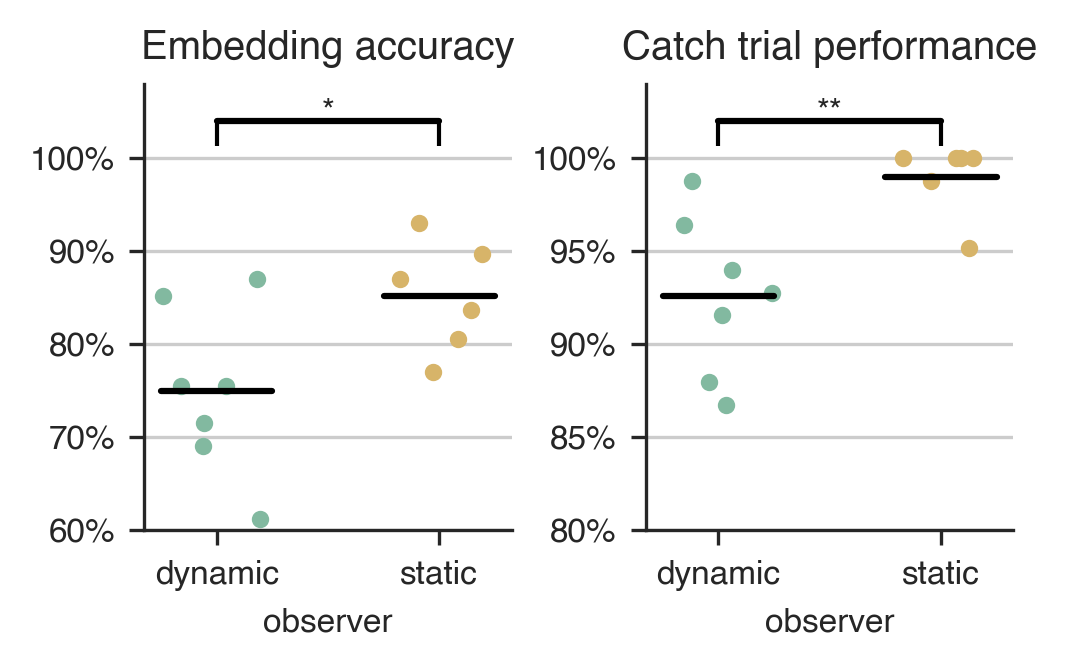

In [17]:
import pylab
from scipy import stats
from scipy.stats import ttest_ind
import seaborn as sb
sb.set_style("ticks")
import matplotlib

matplotlib.rc('font', **font)

names = ['Embedding accuracy','Catch trial performance']
x = np.arange(len(names))

y_head = np.array([scores_df.emb_acc[behaviour_df['head_mover']].mean() ,
         scores_df.trivial_perform[behaviour_df['head_mover']].mean()])
         #scores_df.consistency[behaviour_df['head_mover']].mean()])

y_stable = np.array([scores_df.emb_acc[np.invert(behaviour_df['head_mover'])].mean() ,
           scores_df.trivial_perform[np.invert(behaviour_df['head_mover'])].mean()])
           #scores_df.consistency[np.invert(behaviour_df['head_mover'])].mean()])

y_head_err = np.array([scores_df.emb_acc[behaviour_df['head_mover']].std(),
             scores_df.trivial_perform[behaviour_df['head_mover']].std()])
             #scores_df.consistency[behaviour_df['head_mover']].std()])

y_stable_err = np.array([scores_df.emb_acc[np.invert(behaviour_df['head_mover'])].std() ,
               scores_df.trivial_perform[np.invert(behaviour_df['head_mover'])].std()])
               #scores_df.consistency[np.invert(behaviour_df['head_mover'])].std()])

cm = 1/2.54
fig, ax = plt.subplots(1,2,figsize=(8.8*cm, 5*cm),dpi = 300)
fig.tight_layout()

w = 0.25
#plt.bar(x-w/2,y_head,width = w,label='Dynamic observer',yerr = y_head_err,color = '#000000')
data = scores_df.emb_acc[behaviour_df['head_mover']]
x = np.ones(data.shape)*1 + (np.random.rand(data.shape[0])*w/2.-w/4.)
ax[0].scatter(x-w/2,data,label='Dynamic observer',s = 10,color = color_dynobs)#'#222222')
mean = data.mean()
ax[0].plot([1-3*w/4, 1-w/4],[mean,mean], color="k")

data = scores_df.trivial_perform[behaviour_df['head_mover']]
x = np.ones(data.shape)*2 + (np.random.rand(data.shape[0])*w/2.-w/4.)
ax[1].scatter(x-w/2,data,label='Dynamic observer',s = 10,color = color_dynobs)# '#222222')
mean = data.mean()
ax[1].plot([2-3*w/4, 2-w/4],[mean,mean], color="k")

data = scores_df.emb_acc[np.invert(behaviour_df['head_mover'])]
x = np.ones(data.shape)*1 + (np.random.rand(data.shape[0])*w/2.-w/4.)
ax[0].scatter(x+w/2,data,label='Static observer',s = 10,color = color_statobs)#'#999999')
mean = data.mean()
ax[0].plot([1+w/4, 1+3*w/4],[mean,mean], color="k")

data = scores_df.trivial_perform[np.invert(behaviour_df['head_mover'])]
x = np.ones(data.shape)*2 + (np.random.rand(data.shape[0])*w/2.-w/4.)
ax[1].scatter(x+w/2,data,label='Static observer',s = 10,color = color_statobs)#'#999999')
mean = data.mean()
ax[1].plot([2 + w/4, 2 + 3*w/4],[mean,mean], color="k")


#plt.bar(x+w/2,y_stable,width = w,label='Static observer',yerr = y_stable_err,color = '#999999')

## significance stars
ax[0].plot([1-w/2 , 1+w/2],[1.04 , 1.04],'k',marker=3)
ax[0].text(1,1.04,'*',horizontalalignment='center')

ax[1].plot([2-w/2 , 2+w/2],[1.02 , 1.02],'k',marker=3)
ax[1].text(2,1.02,'**',horizontalalignment='center')

#plt.plot([2-w/2 , 2+w/2],[0.67 , .67],'k',marker=3)
#plt.text(2,.68,'n.s.',horizontalalignment='center')


#ax[0].legend(frameon=False)

ax[0].set_xticks([1-w/2,1+w/2])
ax[1].set_xticks([2-w/2,2+w/2])

ax[0].set_title(names[0])
ax[1].set_title(names[1])

xtickslabels = ['dynamic','static']
ax[0].set_xticklabels(xtickslabels)
ax[1].set_xticklabels(xtickslabels)
ax[0].set_xlabel('observer')
ax[1].set_xlabel('observer')

ax[0].set_ylim([0.6 , 1.08])
ax[1].set_ylim([0.8 , 1.04])
vals = ax[0].get_yticks()
ax[0].set_yticklabels(['{:,.0%}'.format(p) for p in vals])
vals = ax[1].get_yticks()
ax[1].set_yticklabels(['{:,.0%}'.format(p) for p in vals])


#ax.spines[['right', 'top']].set_visible(False)
sb.despine()
ax[0].grid(axis='y')
ax[1].grid(axis='y')
#ttest_ind(scores_df.trivial_perform[behaviour_df['head_mover']],scores_df.trivial_perform[np.invert(behaviour_df['head_mover'])],equal_var = False)
ttest_ind(scores_df.consistency[behaviour_df['head_mover']] , scores_df.consistency[np.invert(behaviour_df['head_mover'])],equal_var = False)
#stats.kstest(scores_df.emb_acc[behaviour_df['head_mover']])
#stats.probplot(scores_df.emb_acc[np.invert(behaviour_df['head_mover'])], dist="norm", plot=pylab)

plt.savefig('head_mover_differences.svg',bbox_inches = 'tight', pad_inches = 0)

In [18]:
scores_df.melt(id_vars='subj').rename(columns=str.title)

,Subj,Variable,Value
0,3,index,0.0
1,4,index,0.0
2,5,index,0.0
3,7,index,0.0
4,8,index,0.0
...,...,...,...
73,12,total_trials,927.0
74,13,total_trials,1071.0
75,14,total_trials,858.0
76,15,total_trials,743.0


In [19]:
# combine dataframes
data = scales_df.merge(behaviour_df,on='subj') # ,'mean_gaze_lat'

# Visualization
Scaling depending on lens
visualize head movement and gaze behaviour

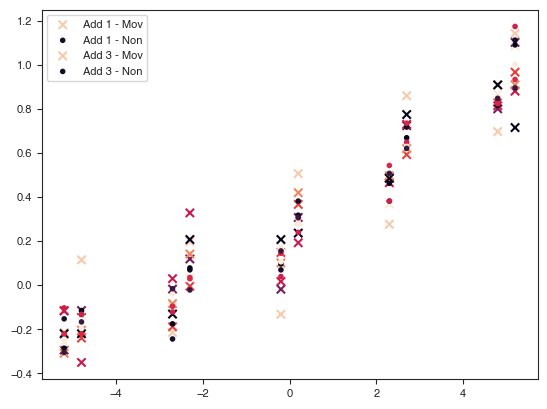

In [21]:
a1 = data[(data['add']==1) & (data.head_mover==True)]
a2 = data[(data['add']==1) & (data.head_mover==False)]

b1 = data[(data['add']==3) & (data.head_mover==True)]
b2 = data[(data['add']==3) & (data.head_mover==False)]

plt.scatter(x=a1.sph-0.2,y=a1.scaling,marker='x',c=a1.mean_gaze_lat,label='Add 1 - Mov')
plt.scatter(x=a2.sph-0.2,y=a2.scaling,marker='.',c=a2.mean_gaze_lat,label='Add 1 - Non')

plt.scatter(x=b1.sph+0.2,y=b1.scaling,marker='x',c=b1.mean_gaze_lat,label='Add 3 - Mov')
plt.scatter(x=b2.sph+0.2,y=b2.scaling,marker='.',c=b2.mean_gaze_lat,label='Add 3 - Non')

plt.legend()

# Mixed LM with random intercept
groups=data["subj"] defines random intercept for subjects

Scales are already aligned, which causes random effects covariance to be singular.


In [28]:
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.tools.sm_exceptions import ConvergenceWarning
md = smf.mixedlm("scaling ~ sph*add*head_mover*omega_total", data, groups=data["subj"])
mdf = md.fit(method=["lbfgs"])
print(mdf.summary())

                               Mixed Linear Model Regression Results
Model:                             MixedLM                Dependent Variable:                scaling
No. Observations:                  143                    Method:                            REML   
No. Groups:                        13                     Scale:                             0.0124 
Min. group size:                   11                     Log-Likelihood:                    inf    
Max. group size:                   11                     Converged:                         Yes    
Mean group size:                   11.0                                                             
----------------------------------------------------------------------------------------------------
                                       Coef.    Std.Err.     z    P>|z|     [0.025         0.975]   
----------------------------------------------------------------------------------------------------
Intercept             

C:\Users\Newton\.conda\envs\default\lib\site-packages\statsmodels\regression\mixed_linear_model.py:1634: UserWarning: Random effects covariance is singular
  warnings.warn(msg)
C:\Users\Newton\.conda\envs\default\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2054: UserWarning: The random effects covariance matrix is singular.
  warnings.warn(_warn_cov_sing)
C:\Users\Newton\.conda\envs\default\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\Newton\.conda\envs\default\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2245: UserWarning: The random effects covariance matrix is singular.
  warnings.warn(_warn_cov_sing)
C:\Users\Newton\.conda\envs\default\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2261: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite

# Mixed LM with random slopes
re_formula="~sph*add" adds random slopes for sph and add and interaction
Scales are already aligned, which causes random effects covariance to be singular.

In [39]:
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.tools.sm_exceptions import ConvergenceWarning
md = smf.mixedlm("scaling ~ sph*add*head_mover*omega_total", data, groups=data["subj"],re_formula="~sph")
mdf = md.fit(method=["lbfgs"])
print(mdf.summary())

                      Mixed Linear Model Regression Results
Model:                      MixedLM          Dependent Variable:          scaling
No. Observations:           143              Method:                      REML   
No. Groups:                 13               Scale:                       0.0124 
Min. group size:            11               Log-Likelihood:              78.8869
Max. group size:            11               Converged:                   No     
Mean group size:            11.0                                                 
---------------------------------------------------------------------------------
                                       Coef.  Std.Err.   z    P>|z| [0.025 0.975]
---------------------------------------------------------------------------------
Intercept                               0.039    0.045  0.847 0.397 -0.051  0.128
head_mover[T.True]                     -0.069    0.065 -1.073 0.283 -0.196  0.057
sph                                   

C:\Users\Newton\.conda\envs\default\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Newton\.conda\envs\default\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2206: ConvergenceWarning: MixedLM optimization failed, trying a different optimizer may help.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\Newton\.conda\envs\default\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2218: ConvergenceWarning: Gradient optimization failed, |grad| = 20.988874
  warnings.warn(msg, ConvergenceWarning)
C:\Users\Newton\.conda\envs\default\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\Newton\.conda\envs\default\lib\site-packages\statsmodels\regression\mixed_linear_mode

In [35]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

mod = smf.ols(formula="scaling ~ sph*add*omega_total*head_mover", data=data)
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                scaling   R-squared:                       0.934
Model:                            OLS   Adj. R-squared:                  0.927
Method:                 Least Squares   F-statistic:                     120.6
Date:                Wed, 26 Jul 2023   Prob (F-statistic):           1.99e-67
Time:                        10:18:12   Log-Likelihood:                 119.31
No. Observations:                 143   AIC:                            -206.6
Df Residuals:                     127   BIC:                            -159.2
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
                                             coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------

### Slope difference between positive and negative sphere

In [10]:
# create boolean for negative sphere
data['neg_sph'] = data['sph']<0

In [11]:
data

,subj,sph,add,scaling,mean_yaw,mean_pitch,mean_roll,mean_gaze_long,mean_gaze_lat,std_gaze_long,std_gaze_lat,head_mover,upper_gaze,neg_sph
0,3,-5.0,1.0,0.025503,3.572365,35.010177,3.546339,0.012889,0.160597,0.050005,0.160949,True,True,True
1,3,-5.0,3.0,0.262184,3.572365,35.010177,3.546339,0.012889,0.160597,0.050005,0.160949,True,True,True
2,3,-2.5,1.0,0.025503,3.572365,35.010177,3.546339,0.012889,0.160597,0.050005,0.160949,True,True,True
3,3,-2.5,3.0,0.322671,3.572365,35.010177,3.546339,0.012889,0.160597,0.050005,0.160949,True,True,True
4,3,0.0,0.0,-0.000000,3.572365,35.010177,3.546339,0.012889,0.160597,0.050005,0.160949,True,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
138,16,0.0,3.0,0.202289,2.527164,2.063913,1.175727,0.042094,0.058825,0.268556,0.278789,False,False,False
139,16,2.5,1.0,0.473415,2.527164,2.063913,1.175727,0.042094,0.058825,0.268556,0.278789,False,False,False
140,16,2.5,3.0,0.627741,2.527164,2.063913,1.175727,0.042094,0.058825,0.268556,0.278789,False,False,False
141,16,5.0,1.0,0.935986,2.527164,2.063913,1.175727,0.042094,0.058825,0.268556,0.278789,False,False,False


In [21]:
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.tools.sm_exceptions import ConvergenceWarning
md = smf.mixedlm("scaling ~ sph:neg_sph + add:neg_sph", data)
mdf = md.fit(method=["lbfgs"])
print(mdf.summary())

AttributeError: 'groups' is a required keyword argument in MixedLM.from_formula